In [88]:
import geopandas as gpd
import s3fs
import pandas as pd
import boto3
import dask_geopandas
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata

In [89]:
# make a list of paths, since this is actually 10 files
def climate_floodplain_pull(
    path='2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip'
):
    """ Build a list of shapefile URIs contained in S3 folder """
    # initiate empty list for s3 URIs
    all_shapefiles = []
    bucket_name = 'ca-climate-index' 
    # initiate s3 session
    session = boto3.Session()
    # use the session to get the resource
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(bucket_name)
    # iterate through directory
    for obj in my_bucket.objects.filter(
        Prefix=path):
        all_shapefiles.append(obj.key)
    return all_shapefiles

In [90]:
climate_floodplain_pull()

['2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip/part.0.parquet',
 '2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip/part.1.parquet',
 '2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip/part.2.parquet',
 '2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip/part.3.parquet',
 '2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip/part.4.parquet',
 '2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip/part.5.parquet',
 '2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip/part.6.parquet',
 '2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip/part.7.parquet',
 '2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinat

In [91]:
# Define the function to pull files from S3
def climate_floodplain_pull(
    path='2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip'
):
    """ Build a list of shapefile URIs contained in S3 folder """
    # initiate empty list for s3 URIs
    all_shapefiles = []
    bucket_name = 'ca-climate-index' 
    # initiate s3 session
    session = boto3.Session()
    # use the session to get the resource
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(bucket_name)
    # iterate through directory
    for obj in my_bucket.objects.filter(Prefix=path):
        all_shapefiles.append(obj.key)
    return all_shapefiles

# Pull list of parquet files from S3
pqt_list = climate_floodplain_pull()
bucket = 'ca-climate-index'

df_list = []
for f in pqt_list:
    bucket_uri = f's3://{bucket}/{f}'
    # Read in as a dask-geopandas GeoDataFrame
    df = dask_geopandas.read_parquet(bucket_uri)
    
    # Perform necessary operations on the dask-geopandas GeoDataFrame
    # Uncomment and modify as needed:
    # df = df.drop(columns=to_drop)
    # df['ISSUED_day'] = df['ISSUED'].str.slice(0, 8)
    # df = df.drop_duplicates(subset=['ISSUED_day', 'USCB_GEOID'], keep='first')
    # df['ISSUED_year'] = df['ISSUED_day'].str.slice(0, 4)
    # df_out = df.groupby(['USCB_GEOID', 'ISSUED_day'])['ISSUED'].count().compute().reset_index().rename(columns={'ISSUED': 'number_warnings'})
    
    # Compute the dask-geopandas GeoDataFrame to a pandas DataFrame
    df_pandas = df.compute()
    df_list.append(df_pandas)

# Concatenate the list of pandas DataFrames
floodplain_data = pd.concat(df_list, ignore_index=True)


In [92]:
floodplain_data.head()

,hilbert_distance,Shape_Leng,Group,FloodZone,County,FLD_ZONE,geometry,index_right,USCB_GEOID,USCB_NAME
0,430541373,9851.466096,FEMA Effective,500,Ventura,X500,"POLYGON ((-119.26947 34.25026, -119.26952 34.2...",3864402159,06111002500,25
1,430541373,9851.466096,FEMA Effective,500,Ventura,X500,"POLYGON ((-119.26947 34.25026, -119.26952 34.2...",3864377162,06111002400,24
2,430574631,1325.018174,FEMA Effective,500,Ventura,X PROTECTED BY LEVEE,"POLYGON ((-119.30665 34.27998, -119.30675 34.2...",3864377162,06111002400,24
3,430574631,1325.018174,FEMA Effective,500,Ventura,X PROTECTED BY LEVEE,"POLYGON ((-119.30665 34.27998, -119.30675 34.2...",3864348466,06111002302,23.02
4,430578338,15170.736519,FEMA Effective,500,Ventura,X PROTECTED BY LEVEE,"POLYGON ((-119.29790 34.30918, -119.29787 34.3...",3864377162,06111002400,24


In [93]:
floodplain_data.FloodZone.unique()

array(['500', '100', None], dtype=object)

<Axes: >

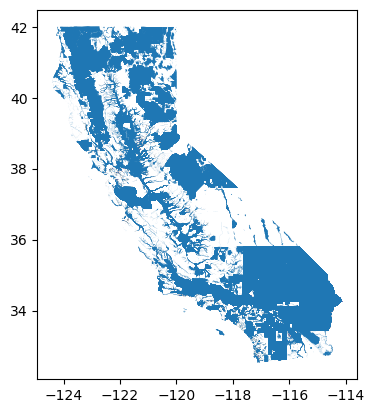

In [94]:
floodplain_data.plot()

In [95]:
# selecting relevant columns for processing
selected_columns = ['USCB_GEOID', 'County', 'FloodZone', 'geometry']

floodplain_columns = floodplain_data[selected_columns]

one_hundred_yr_floodplain = floodplain_columns[floodplain_columns['FloodZone'] == '100']
one_hundred_yr_floodplain_drop_duplicates = one_hundred_yr_floodplain.drop_duplicates(['geometry'], keep='first')
one_hundred_yr_floodplain_drop_duplicates

,USCB_GEOID,County,FloodZone,geometry
10,06111002400,Ventura,100,"POLYGON ((-119.29620 34.33233, -119.29620 34.3..."
12,06111009700,Ventura,100,"POLYGON ((-119.45099 34.39876, -119.45102 34.3..."
13,06111009700,Santa Barbara,100,"POLYGON ((-119.45342 34.39617, -119.45371 34.3..."
14,06111009700,Santa Barbara,100,"POLYGON ((-119.47545 34.37968, -119.47523 34.3..."
16,06111002302,Ventura,100,"POLYGON ((-119.29810 34.30771, -119.29809 34.3..."
...,...,...,...,...
63537,06025012400,Imperial,100,"POLYGON ((-114.46899 32.89379, -114.46863 32.8..."
63538,06025940000,Imperial,100,"POLYGON ((-114.47307 32.87550, -114.47394 32.8..."
63540,06025940000,Imperial,100,"POLYGON ((-114.47132 32.87145, -114.47141 32.8..."
63541,06025940000,Imperial,100,"POLYGON ((-114.46733 32.85947, -114.46788 32.8..."


In [96]:
# Count the total number of duplicates in the geometry column
duplicate_count = one_hundred_yr_floodplain.duplicated(subset=['geometry']).sum()

print(f"Number of dropped duplicate geometries: {duplicate_count}")

Number of dropped duplicate geometries: 12479


In [97]:
# read in CA census tiger file
ca_tract_county = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_tract_county = gpd.read_file(ca_tract_county)
ca_tract_county = ca_tract_county.drop(columns={'field_1', 'geometry'})
ca_tract_county.columns = ca_tract_county.columns.str.lower()
ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)

C:\Users\jespi\AppData\Local\Temp\ipykernel_36684\4083292558.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)


In [98]:
# read in CA spatial census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries = ca_boundaries[['GEOID', 'geometry']]
ca_boundaries = ca_boundaries.rename(columns={'GEOID':'tract'})

In [99]:
# merge the two CA tract datasets together
ca_tract_county_spatial = pd.merge(ca_tract_county, ca_boundaries, on='tract', how='left')
ca_tract_county_spatial = ca_tract_county_spatial.rename(columns={'tract':'USCB_GEOID'})
ca_tract_county_spatial

,USCB_GEOID,countyfp,county,geometry
0,06085504321,085,santa clara,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06085504410,085,santa clara,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06085507003,085,santa clara,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06085507004,085,santa clara,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,085,santa clara,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...,...
9124,06059001303,059,orange,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06059001304,059,orange,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06059001401,059,orange,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06013367200,013,contra costa,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


In [100]:
geo_ca_tract_county = gpd.GeoDataFrame(ca_tract_county_spatial)

In [101]:
# Step 1: Check the CRS
print("Initial CRS of protected areas:", one_hundred_yr_floodplain_drop_duplicates.crs)
print("Initial CRS of CA tract/counties dataset:", geo_ca_tract_county.crs)

# Step 2: Reproject to an appropriate CRS for area calculations
gdf1 = one_hundred_yr_floodplain_drop_duplicates.to_crs(epsg=3310)  # California Albers
gdf2 = geo_ca_tract_county.to_crs(epsg=3310)  # California Albers

print("Reprojected CRS of cnra protected areas:", gdf1.crs)
print("Reprojected CRS of Counties:", gdf2.crs)

# Check for and fix invalid geometries in both GeoDataFrames
gdf1['geometry'] = gdf1['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)
gdf2['geometry'] = gdf2['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

# Verify if all geometries are now valid
print("Protected areas geometries valid:", gdf1.is_valid.all())
print("County geometries valid:", gdf2.is_valid.all())

# Step 3: Calculate the total area of floodplain areas per tract
floodplain_area_tract = gdf1.dissolve(by='USCB_GEOID', aggfunc='sum')['geometry'].area.reset_index(name='floodplain_tract_area')

# Step 4: Calculate the total area of each tract
tract_area = gdf2.dissolve(by='USCB_GEOID', aggfunc='sum')['geometry'].area.reset_index(name='tract_area')

# Step 5: Merge the two datasets on the county column
merged_df = pd.merge(tract_area, floodplain_area_tract, on='USCB_GEOID', how='left')

# Step 6: Calculate the spatial percentage of NTMPs per county
merged_df['protected_areas_percentage'] = (merged_df['floodplain_tract_area'] / merged_df['tract_area']) * 100  

# Display the results where the percentage exceeds 100 for further investigation
over_100_percent = merged_df[merged_df['protected_areas_percentage'] > 100]
print('number of entries over 100 percent:', len(over_100_percent))

Initial CRS of protected areas: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "NAD83", "datum": {"type": "GeodeticReferenceFrame", "name": "North American Datum 1983", "ellipsoid": {"name": "GRS 1980", "semi_major_axis": 6378137, "inverse_flattening": 298.257222101}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Geodesy.", "area": "North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Io

In [102]:
merged_df.protected_areas_percentage.max()

32889.556378267844

In [103]:
merged_df.to_csv('climate_floodplain_areas_metric.csv')

## Function Call

In [104]:
@append_metadata
def floodplain_areas_upload(input_csv, export=False, varname=''):
    '''
    Uploads the floodplain areas metric to S3 bucket. The metric is:
    
    * % of tract in 100 year floodplain area

    Data for this metric was sourced from the Koordinates at:
    https://koordinates.com/layer/96056-california-fema-100-year-floodplains/

    Methods
    -------
    Relevant data columns were isolated.
    One hundred year floodplain entries were filtered for.
    Data was reprojected to match California tract data.
    Using both datasets 'geometry' columns, a total area column for each tract entry was calculated.
    Estimated tract percentage under management practices was calculated by dividing estimated tract floodplain land
    by estimated total tract area.
    
    Parameters
    ----------
    input_csv: string
        csv floodplain areas metric data 
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI floodplain areas metric to AWS
        True = will upload resulting df containing CAL CRAI floodplain areas metric to AWS

    Script
    ------
    climate_floodplain.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: relevant columns were isolated and renamed')
    print('Data transformation: data reprojected to epsg 3310')
    print('Data transformation: a new column was created to estimate percentage of each tract with management practices')

    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [input_csv]
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{input_csv} uploaded to AWS.')
 
    '''if os.path.exists(input_csv):
        os.remove(input_csv)'''

In [86]:
input_csv = 'climate_floodplain_areas_metric.csv'
variable = 'climate_koordinates_floodplain'

floodplain_areas_upload(input_csv, varname='test', export=True)